In [432]:
import pandas as pd
import numpy as np
import pymysql, pickle
import matplotlib.pyplot as plt
from collections import Counter

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from warnings import filterwarnings

filterwarnings("ignore", category=UserWarning)

In [396]:
def load_data():

    # Read Password
    pw = pickle.load(open('pw.pkl', 'rb'))
    host_ = pickle.load(open('host.pkl', 'rb')) 
    
    # AWS MySql Connection Info
    db = pymysql.connect(
        host = host_,
        user = "root",
        password = pw,
        db = "usedcar",
        charset='utf8',
    )

    SQL_QUERY = """
        SELECT *
        FROM usedcar;
    """

    train = pd.read_sql(SQL_QUERY, db)
    pickle.dump(train, open("train.pkl", "wb"))

    return train

In [397]:
train = load_data()
train.head()

,index,ID,Year,Brand,Model,Mileage,Bodystyle,Dealer,Exterior Color,Interior Color,Drivetrain,MPG,Fuel Type,Transmission,Engine,Price
0,0,2023kianiro_plug_in_hybrid10318ourismanfairfaxkia,2023,kia,niro_plug_in_hybrid,10318,suv,ourisman fairfax kia,snow white pearl,charcoal,front-wheel,–,hybrid,6-speed automatic with auto-shift,1.6l i4 16v gdi dohc hybrid,32850
1,1,2018porschepanamera39696tedbrittford-wewillbuy...,2018,porsche,panamera,39696,hatchback,ted britt ford - we will buy your car,night blue metallic,luxor beige,all-wheel,21–27,gasoline,8-speed automatic with auto-shift,3.0l v6 24v gdi dohc turbo,52483
2,2,2020fordf_15092951tedbrittford-wewillbuyyourcar,2020,ford,f_150,92951,pickup_truck,ted britt ford - we will buy your car,ford performance blue metallic,blue,four-wheel,15–18,gasoline,10-speed automatic,3.5l v6 24v pdi dohc twin turbo,46142
3,3,2020acuratlx21651saffordbrownhyundaifairfax,2020,acura,tlx,21651,sedan,safford brown hyundai fairfax,red,red,front-wheel,23–32,gasoline,8-speed dual-clutch,"2.4l i-4 gasoline direct injection, dohc, i-vt...",27495
4,4,2023genesisgv7025105saffordbrownhyundaifairfax,2023,genesis,gv70,25105,suv,safford brown hyundai fairfax,himalayan gray,obsidian black,all-wheel,22–28,gasoline,8-speed automatic with shiftronic,"2.5l i-4 port/direct injection, dohc, variable...",39795


In [399]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37356 entries, 0 to 37355
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   index           37356 non-null  int64 
 1   ID              37356 non-null  object
 2   Year            37356 non-null  int64 
 3   Brand           37356 non-null  object
 4   Model           37356 non-null  object
 5   Mileage         37356 non-null  int64 
 6   Bodystyle       37356 non-null  object
 7   Dealer          37356 non-null  object
 8   Exterior Color  37356 non-null  object
 9   Interior Color  37356 non-null  object
 10  Drivetrain      37356 non-null  object
 11  MPG             36559 non-null  object
 12  Fuel Type       36559 non-null  object
 13  Transmission    36559 non-null  object
 14  Engine          36559 non-null  object
 15  Price           37356 non-null  int64 
dtypes: int64(4), object(12)
memory usage: 4.6+ MB


In [400]:
train.describe()

,index,Year,Mileage,Price
count,37356.000000,37356.000000,37356.000000,37356.000000
mean,2934.412169,2018.054422,50777.997725,37525.623943
std,2063.487439,5.874374,42005.575918,26924.532753
min,0.000000,1968.000000,138.000000,3798.000000
25%,1184.000000,2016.000000,21079.000000,20998.000000
50%,2588.000000,2020.000000,40405.000000,32493.000000
75%,4404.000000,2021.000000,69425.000000,45701.000000
max,8273.000000,2024.000000,345741.000000,335000.000000


### Remove the duplicated data

In [401]:
train = train.drop_duplicates(['ID'])
train.count()

index             1207
ID                1207
Year              1207
Brand             1207
Model             1207
Mileage           1207
Bodystyle         1207
Dealer            1207
Exterior Color    1207
Interior Color    1207
Drivetrain        1207
MPG               1181
Fuel Type         1181
Transmission      1181
Engine            1181
Price             1207
dtype: int64

### The 40 most popular brands

In [402]:
# Top 40 car brands
brand_list = []
for brand in Counter(train.Brand).most_common(40):
    brand_list.append(brand[0])

In [403]:
# Check the index of data not included in the top 40 car brands
idx_list = []
idx = 0
for brand in train["Brand"]:
    if brand not in brand_list:
        print(f"Brands that are not among the 40 most popular brands : {brand}")
        idx_list.append(idx)
    idx += 1

Brands that are not among the 40 most popular brands : aston_martin
Brands that are not among the 40 most popular brands : rivian


In [404]:
# Only the top 40 car brands are filtered
train = train.drop(idx_list)
train.reset_index(drop=True, inplace=True)

# Drop the index
train = train.drop("index", axis=1)

### Feature engineering

In [405]:
# Select models and brands as category variables
categorical_features = ['Brand', 'Model', 'Bodystyle', 'Exterior Color', 'Interior Color', 'Drivetrain',\
                            'MPG','Fuel Type', 'Transmission','Engine']

# categorical_features = ['Brand', 'Model']

In [406]:
# Dummy category variable
dummy_cat = pd.get_dummies(train[categorical_features])
dummy_cat.head()

,Brand_acura,Brand_aston_martin,Brand_audi,Brand_bentley,Brand_bmw,Brand_buick,Brand_cadillac,Brand_chevrolet,Brand_chrysler,Brand_dodge,...,Engine_regular unleaded v-6 3.8 l/231,Engine_turbocharged gas v8 6.2l/376,Engine_twin turbo premium unleaded v-6 3.4 l/210,Engine_twin turbo premium unleaded v-8 4.0 l/243,Engine_twin turbo premium unleaded v-8 4.4 l/268,Engine_v6,Engine_v8,"Engine_vq 3.5l v-6 dohc, variable valve control, premium unleaded, engi","Engine_vq 3.7l v-6 dohc, variable valve control, premium unleaded, engi","Engine_vq 4l v-6 dohc, variable valve control, regular unleaded, engine"
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [408]:
# Select by numeric variable
numerical_features = ['Year', 'Mileage', 'Price']

In [409]:
normalize_num = np.log1p(train[numerical_features])

In [410]:
normalize_num.head()

,Year,Mileage,Price
0,7.612831,9.241742,10.399737
1,7.610358,10.589031,10.868264
2,7.611348,11.439839,10.739501
3,7.611348,9.982853,10.221796
4,7.612831,10.130862,10.591522


In [411]:
# Join numeric variable with categoric variable
X_train_0 = normalize_num.join(dummy_cat)

# Seperate price as y value
y_train = X_train_0["Price"]
X_train = X_train_0.drop("Price", axis=1)

### Model : XGBoost Model
XGBoost is short for “Extreme Gradient Boosting”, where the term “Gradient Boosting” is proposed in the paper Greedy Function Approximation: A Gradient Boosting Machine, by Friedman. XGBoost is based on this original model.

XGBoost is used for supervised learning problems, where we use the training data (with multiple features) x to predict a target variable y. 

In [412]:
# K-ford : 10
k_fold = KFold(n_splits=10, shuffle=True, random_state=2024)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train)

In [413]:
ml = XGBRegressor(n_estimators=1000, learning_rate=0.05, verbose=False)

In [414]:
# Check the corss validation score
%time score = cross_val_score(ml, X_train, y_train, cv=k_fold, n_jobs=-1, scoring="r2").mean()
print("Score = {0:.5f}".format(score))

CPU times: user 127 ms, sys: 138 ms, total: 264 ms
Wall time: 25.7 s
Score = 0.84750


/Users/danny/anaconda3/envs/python38/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [16:09:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


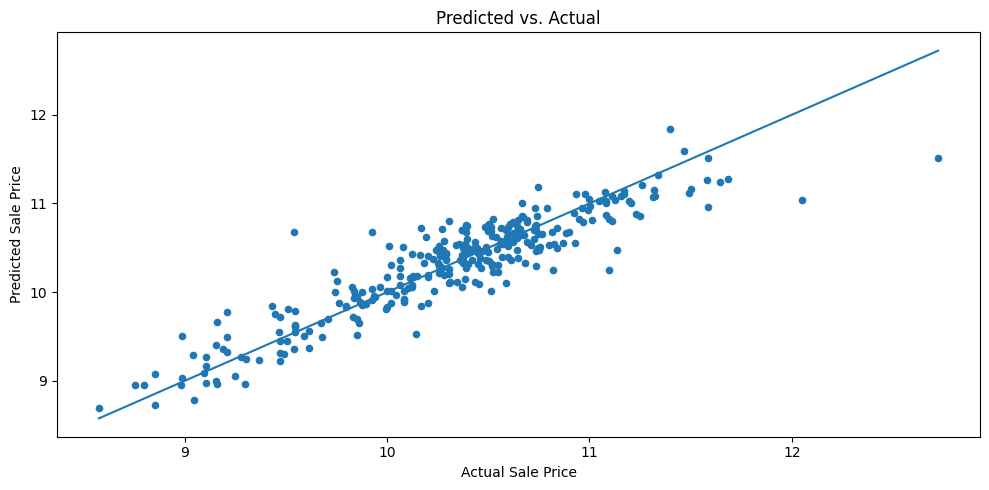

In [415]:
# Train model
ml = ml.fit(X_train1, y_train1, verbose=False)

# Predict test data set
y_pred = ml.predict(X_test1)

# Drawing regression graph
plt.figure(figsize=(10, 5))
plt.scatter(y_test1, y_pred, s=20)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

plt.plot([min(y_test1), max(y_test1)], [min(y_test1), max(y_test1)])
plt.tight_layout()

In [416]:
brand = 'honda'
model = 'accord'
year = int(2010)
mileage = int(150000)

target = pd.DataFrame(columns=[X_train1.columns])

In [417]:
brand_index = 0
for col in X_train1.columns:
    if col == 'Brand' + "_" + brand:
        break;
    brand_index += 1
brand_index

16

In [418]:
# Check the index location of the selected used car model in the variable column data frame
model_index = 0
for col in X_train1.columns:
    if col == 'Model' + "_" + model:
        break;
    model_index += 1
    
model_index

81

In [419]:
# Array of zeros
target_list = np.zeros_like(X_train1.iloc[0])

In [420]:
# Put the number 1 in the selected brand and model locations in the data frame
target_list[brand_index] = 1
target_list[model_index] = 1

In [421]:
# Put the year and miles in the data frame
target_list[0] = year
target_list[1] = mileage

In [422]:
# Convert all elements in target_list with 0 being False and 1 being True
transformed_values = [True if x == 1 else False for x in target_list[2:]]
target_list = [target_list[0], target_list[1]] + transformed_values

In [423]:
# Insert data into target data frame
for i in range(1):
    target.loc[i] = target_list

In [424]:
numerical_features = ['Year', 'Mileage']

In [425]:
target[numerical_features]

,Year,Mileage
0,2010,150000


In [426]:
# Convert the values ​​in the Year and Mileage columns to float form and apply the log1p function
normalize_target = target[numerical_features].astype(float).apply(np.log1p)
print(normalize_target)

       Year    Mileage
0  7.606387  11.918397


In [427]:
# After deleting the Year and Mileage columns, combine them with the normalize_target dataframe to create target_goal.
target.drop(['Year', 'Mileage'], axis=1, level=0, inplace=True)
target_goal = normalize_target.join(target)
target_goal

/var/folders/yd/fz6tljkd6410lpk0jbrx_jgc0000gn/T/ipykernel_5042/2404028275.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  target.drop(['Year', 'Mileage'], axis=1, inplace=True)


,Year,Mileage,Brand_acura,Brand_aston_martin,Brand_audi,Brand_bentley,Brand_bmw,Brand_buick,Brand_cadillac,Brand_chevrolet,...,Engine_regular unleaded v-6 3.8 l/231,Engine_turbocharged gas v8 6.2l/376,Engine_twin turbo premium unleaded v-6 3.4 l/210,Engine_twin turbo premium unleaded v-8 4.0 l/243,Engine_twin turbo premium unleaded v-8 4.4 l/268,Engine_v6,Engine_v8,"Engine_vq 3.5l v-6 dohc, variable valve control, premium unleaded, engi","Engine_vq 3.7l v-6 dohc, variable valve control, premium unleaded, engi","Engine_vq 4l v-6 dohc, variable valve control, regular unleaded, engine"
0,7.606387,11.918397,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Predict Used_Car Values

In [428]:
# Predicted logged price
price_log = ml.predict(target_goal)

In [429]:
# Revert the logged price back to its original price
price = np.exp(price_log)
print(f"Brand : {brand.upper()}")
print(f"Model : {model.upper()}")
print(f"Year  : {year}")
print(f"Estimated Price : ${int(price)}")

Brand : HONDA
Model : ACCORD
Year  : 2010
Estimated Price : $8539


### Compare same model with different years

In [431]:
# Find the average of the same model for each year
actual_car_info = train[["Brand", "Model", "Year", "Mileage", "Price"]]

same_model = actual_car_info[actual_car_info["Model"]== model] 
year_price = same_model[["Year","Price"]]
year_price_list = year_price.groupby("Year").agg({'Price':np.mean}).astype('int')
year_price_list = year_price_list.reset_index()
year_price_list

,Year,Price
0,2010,9725
1,2012,10450
2,2014,13250
3,2016,13495
4,2018,21285
5,2019,25825
6,2020,27993


/Users/danny/anaconda3/envs/python38/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [16:08:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/danny/anaconda3/envs/python38/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [16:08:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/danny/anaconda3/envs/python38/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [16:08:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/danny/anaconda3/envs/python38/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [16:08:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarni